In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi

In [ ]:
from osp_solutions.circuits_initial import gate_initial_state
from osp_solutions.circuits_1d_path import gate_path_triangle_parallel
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg_path
from osp_solutions.backend_simulator import result_to_dms, make_dm_binary, hamiltonian_to_dm, DMExtended
from setting import *

In [4]:
dt = Parameter(r"$\Delta t$")
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial,
                                                    endian_binary="big",
                                                    endian_dm="little")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

True

In [5]:
fidelities = []
nums_cnots = []

print("trotter step list: ", nums_steps_triangle)
for num_steps in nums_steps_triangle:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    qc.compose(gate_initial_state(state_initial=state_initial),
               qubits=list(range(num_qubits)),
               inplace=True,)
    
    qc.append(instruction=gate_path_triangle_parallel(num_qubits=num_qubits,
                                             num_steps=num_steps // 4, ###!
                                             dt=dt * 2, ###!
                                             type_H_eff=type_H_eff_triangle,
                                             to_instruction=False,
                                             add_barrier=False,
                                          ),
              qargs=list(range(num_qubits)),
             )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_noisy.run(qc_t3,
                                     shots=0,
                                    ).result()
    dm_raw = result_to_dms(result=result_raw,
                           endian_result="little",
                           endian_dm="little",
                          )[0]

    fidelities.append(qi.state_fidelity(dm_raw, state_target_dm))
    nums_cnots.append(qc_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print("raw state tomography fidelity = {:.4f}".format(fidelities[-1]))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter step list:  [  8  24  40  56  72  88 104 120 136 152 168 184 200 216 232 248 264 280
 296 312 328 344 360 376 392]
trotter steps:  8
raw state tomography fidelity = 0.0017
number of CNOT gates: 112
time: 1.3647411249112338

trotter steps:  24
raw state tomography fidelity = 0.4351
number of CNOT gates: 328
time: 0.8927992498502135

trotter steps:  40
raw state tomography fidelity = 0.8664
number of CNOT gates: 544
time: 1.3235539169982076

trotter steps:  56
raw state tomography fidelity = 0.9441
number of CNOT gates: 760
time: 1.5158518750686198

trotter steps:  72
raw state tomography fidelity = 0.9652
number of CNOT gates: 976
time: 1.8860906660556793

trotter steps:  88
raw state tomography fidelity = 0.9724
number of CNOT gates: 1192
time: 2.31204970786348

trotter steps:  104
raw state tomography fidelity = 0.9749
number of CNOT gates: 1408
time: 2.47775458288379

trotter steps:  120
raw state tomography fidelity = 0.9753
number of CNOT gates: 1624
time: 2.851130874827504

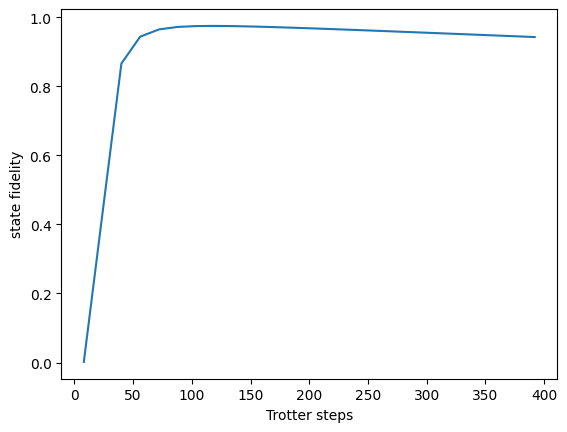

In [6]:
plt.clf()
plt.plot(nums_steps_triangle, fidelities)
plt.xlabel("Trotter steps") 
plt.ylabel("state fidelity")
plt.show()

In [7]:
with open("run_triangle_parallel.pkl", "wb") as f:
    pickle.dump(obj={"nums_steps_triangle": nums_steps_triangle, 
                     "fidelities": fidelities, 
                     "nums_cnots": nums_cnots},
                file=f)

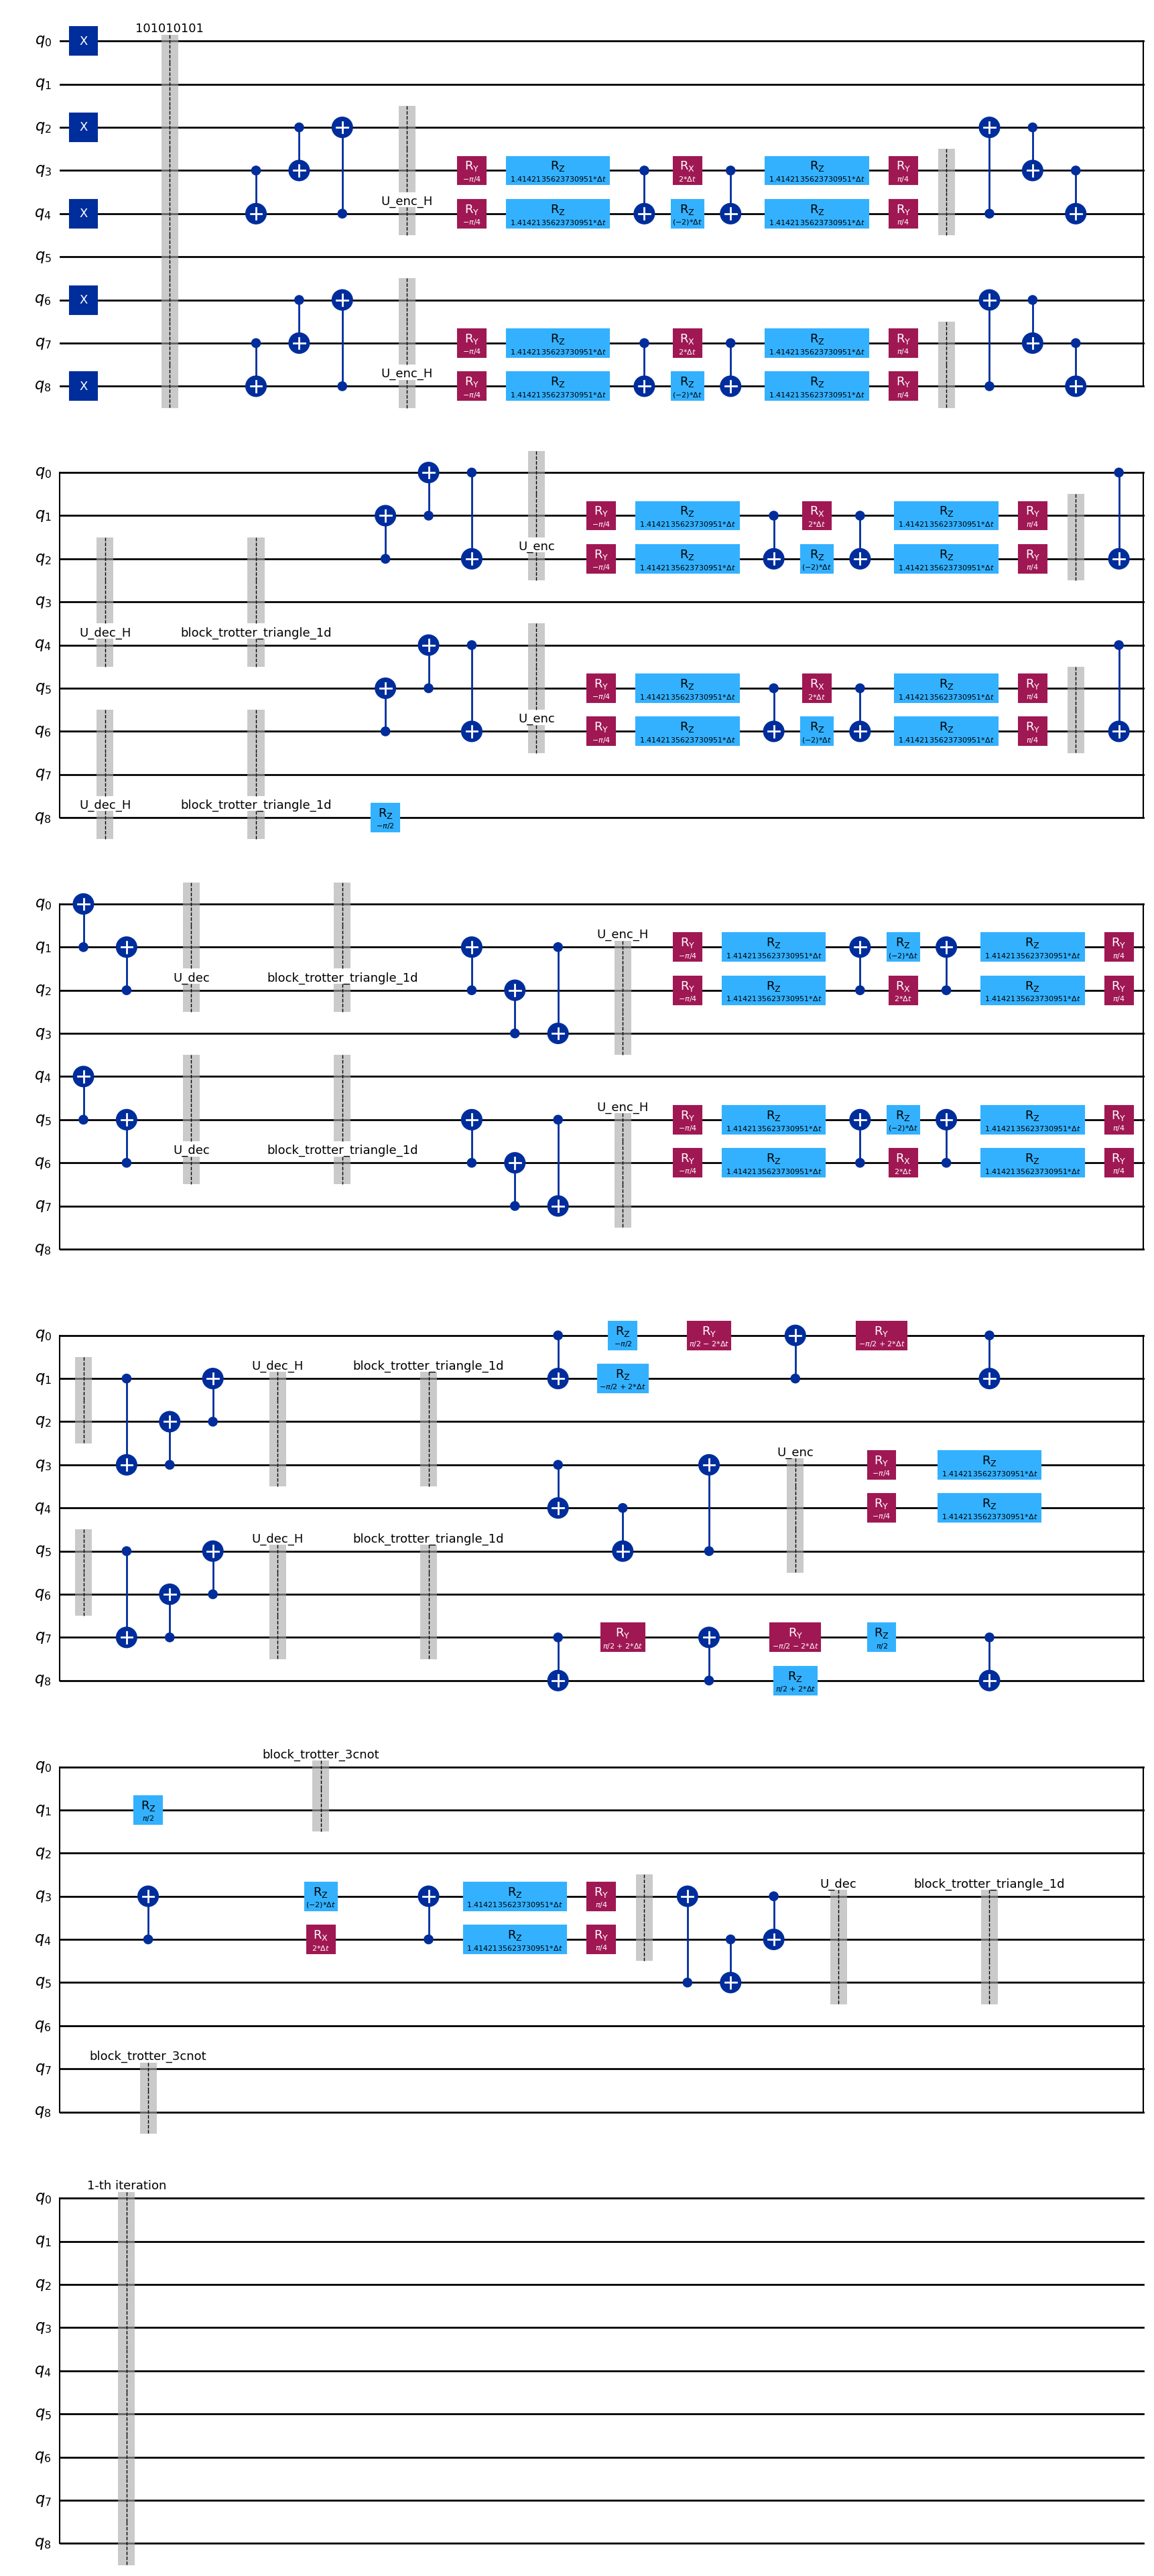

In [8]:
qc = QuantumCircuit(num_qubits)
qc.compose(gate_initial_state(state_initial=state_initial,
                              to_instruction=False,
                              add_barrier=True,),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.compose(gate_path_triangle_parallel(num_qubits=num_qubits,
                                            num_steps=1, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff_triangle,
                                            to_instruction=False,
                                            add_barrier=True,
                                        ),
            qubits=list(range(num_qubits)),
            inplace=True,
            )
qc.draw("mpl")

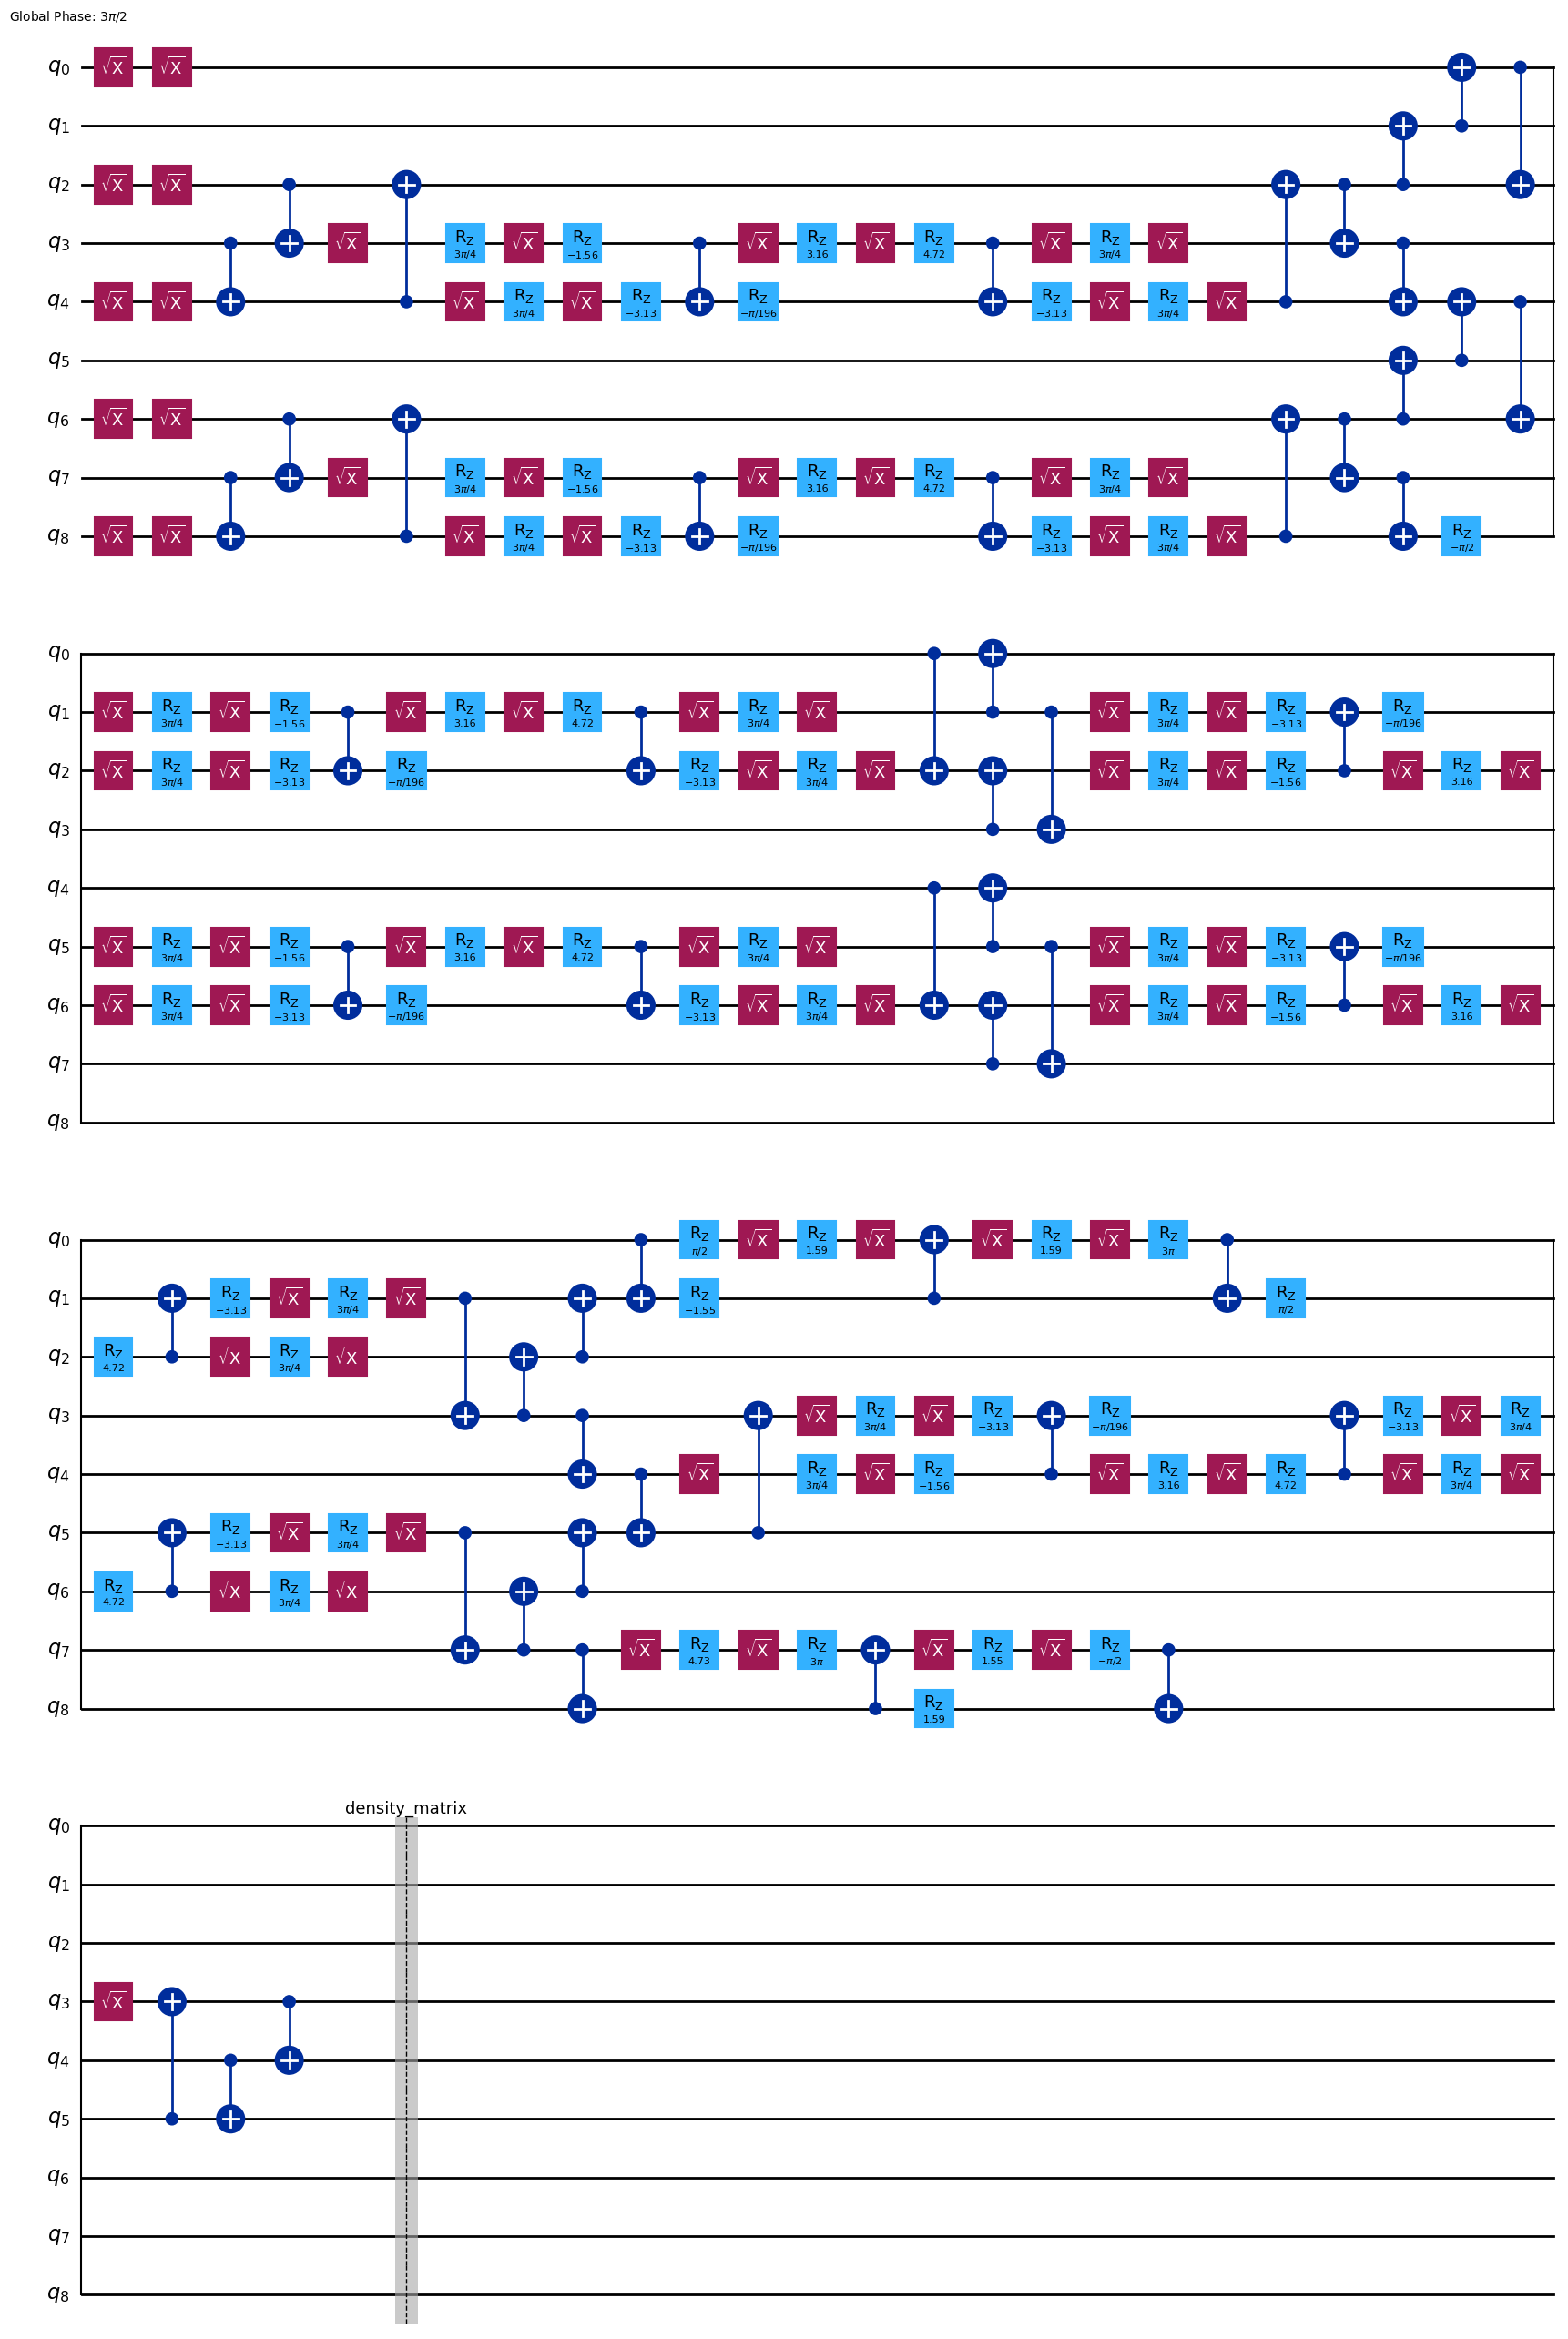

In [9]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
qc.compose(gate_initial_state(state_initial=state_initial),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.append(instruction=gate_path_triangle_parallel(num_qubits=num_qubits,
                                            num_steps=1, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff_triangle,
                                            to_instruction=False,
                                            add_barrier=False,
                                        ),
            qargs=list(range(num_qubits)),
            )

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
# qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3 = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
qc_t3.draw("mpl")